# UMAP

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from snakeclef.utils import get_spark
from pyspark.sql import functions as F
import umap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

spark = get_spark()
display(spark)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/01 21:02:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/07/01 21:02:57 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [3]:
# Path and dataset names
gcs_path = "gs://dsgt-clef-snakeclef-2024/data"
dct_emb_path = "process/training_small_v2/dino_dct/data"
cls_emb_path = "process/training_small_v2/dino_cls_token/data"
train_path = "parquet_files/SnakeCLEF2023-train-small_size"

# Define the GCS path to the embedding files
dct_gcs_path = f"{gcs_path}/{dct_emb_path}"
cls_gcs_path = f"{gcs_path}/{cls_emb_path}"
train_gcs_path = f"{gcs_path}/{train_path}"

# Read the Parquet file into a DataFrame
dct_df = spark.read.parquet(dct_gcs_path)
cls_df = spark.read.parquet(cls_gcs_path)
train_df = spark.read.parquet(train_gcs_path)

# Show the data
dct_df.show(n=5, truncate=50)
cls_df.show(n=5, truncate=50)
train_df.show(n=5, truncate=50)

+--------------------------------------------------+--------+--------------------------------------------------+
|                                              path|class_id|                                     dct_embedding|
+--------------------------------------------------+--------+--------------------------------------------------+
|/SnakeCLEF2023-small_size/2022/Elaphe_climacoph...|     613|[-28974.48, 7672.744, -4691.4995, 11828.723, -8...|
|/SnakeCLEF2023-small_size/2022/Hypsiscopus_plum...|     841|[-21142.348, 20861.281, 3963.4922, 7255.119, -1...|
|/SnakeCLEF2023-small_size/2020/Vipera_ammodytes...|    1734|[-24255.254, 21216.314, -10260.628, 3223.9844, ...|
|/SnakeCLEF2023-small_size/2021/Salvadora_desert...|    1485|[-15043.547, 16881.87, -22459.178, -2952.832, 6...|
|/SnakeCLEF2023-small_size/2016/Sibon_sanniolus/...|    1505|[-25471.205, -4602.5293, -8869.634, 9133.318, 2...|
+--------------------------------------------------+--------+-----------------------------------

+---------------------------------------------+--------------------------------------------------+------------------------+----+---------------------------+-------------+--------------------------------------------------+--------------+-------+----+--------+------+
|                                   image_path|                                              path|             folder_name|year|              binomial_name|    file_name|                                              data|observation_id|endemic|code|class_id|subset|
+---------------------------------------------+--------------------------------------------------+------------------------+----+---------------------------+-------------+--------------------------------------------------+--------------+-------+----+--------+------+
|       1993/Phrynonax_polylepis/102870166.jpg|/SnakeCLEF2023-small_size/1993/Phrynonax_polyle...|SnakeCLEF2023-small_size|1993|        Phrynonax_polylepis|102870166.jpg|[FF D8 FF E0 00 10 4A 46 49 46 0

## UMAP plot

In [4]:
from pyspark.sql import DataFrame


def prepare_emb_df(
    df: DataFrame, train_df: DataFrame, col_name: str, num_top_species: int = 5
):
    # Transformation
    grouped_df = (
        df.groupBy("class_id")
        .agg(F.count("class_id").alias("n"))
        .orderBy(F.col("n").desc())
    )
    # Get top species DF
    top_species = [
        int(row["class_id"]) for row in grouped_df.limit(num_top_species).collect()
    ]
    print(f"Top {num_top_species} class ids: {top_species}")

    subset_df = df.filter(F.col("class_id").isin(top_species)).select(
        ["path", "class_id", col_name]
    )

    subset_df = subset_df.join(train_df, "path", "inner").select(
        [subset_df.class_id, train_df.binomial_name, subset_df[col_name]]
    )
    return subset_df

In [5]:
# Get dataframe
dct_sub_df = prepare_emb_df(
    df=dct_df, train_df=train_df, col_name="dct_embedding", num_top_species=5
)

Top 5 class ids: [1137, 387, 1138, 1736, 849]


In [6]:
from sklearn.preprocessing import StandardScaler


def get_pandas_embeddings(df: DataFrame, col_name: str):
    # Convert to Pandas DF
    pandas_df = df.select([col_name, "binomial_name"]).toPandas()

    # Extract features and labels
    emb_df = np.stack(pandas_df[col_name].values)
    scaled_emb = StandardScaler().fit_transform(emb_df)

    # UMAP reduction
    reducer = umap.UMAP(
        n_neighbors=15, n_components=2, metric="euclidean", random_state=42
    )
    embedding = reducer.fit_transform(
        scaled_emb
    )  # NumPy array with shape (n_samples, 2)
    return pandas_df, embedding, scaled_emb

In [7]:
# get pandas_df, embeddings
dct_pandas_df, dct_embedding, dct_scaled_emb = get_pandas_embeddings(
    df=dct_sub_df, col_name="dct_embedding"
)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [8]:
def plot_cluster(pandas_df, embeddings, algorithm_name, emb_name, top_5: bool = True):
    # Plot the data
    fig, ax = plt.subplots(figsize=(6.4, 4.8), dpi=200)
    if emb_name == "CLS":
        emb_name = f"[{emb_name}]"
    title = (
        f"{algorithm_name} projection of selected snake species, {emb_name} embeddings"
    )
    if top_5:
        title = (
            f"{algorithm_name} projection of top 5 snake species, {emb_name} embeddings"
        )
    fig.suptitle(
        t=title,
        fontsize=12,
        weight="bold",
    )

    # Create a scatter plot, color-coded by new species_idx
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
    top_species_idx = pandas_df["binomial_name"].value_counts().nlargest(5).index
    species_to_color = {species: colors[i] for i, species in enumerate(top_species_idx)}

    # Map species IDs to colors for plotting
    color_list = pandas_df["binomial_name"].map(species_to_color).tolist()

    for species, color in species_to_color.items():
        # Select embeddings for the current species
        idx = pandas_df["binomial_name"] == species
        ax.scatter(
            embeddings[idx, 0],
            embeddings[idx, 1],
            c=color,
            # cmap="tab10",
            label=species.replace("_", " "),
            s=5,
            alpha=0.7,
            linewidth=0.5,
        )

    ax.grid(color="blue", linestyle="--", linewidth=1, alpha=0.2)
    ax.legend(loc="best", title="Species Name", fontsize="small")
    for spine in ["top", "right", "bottom", "left"]:
        ax.spines[spine].set_visible(False)
    fig.tight_layout()
    plt.show()

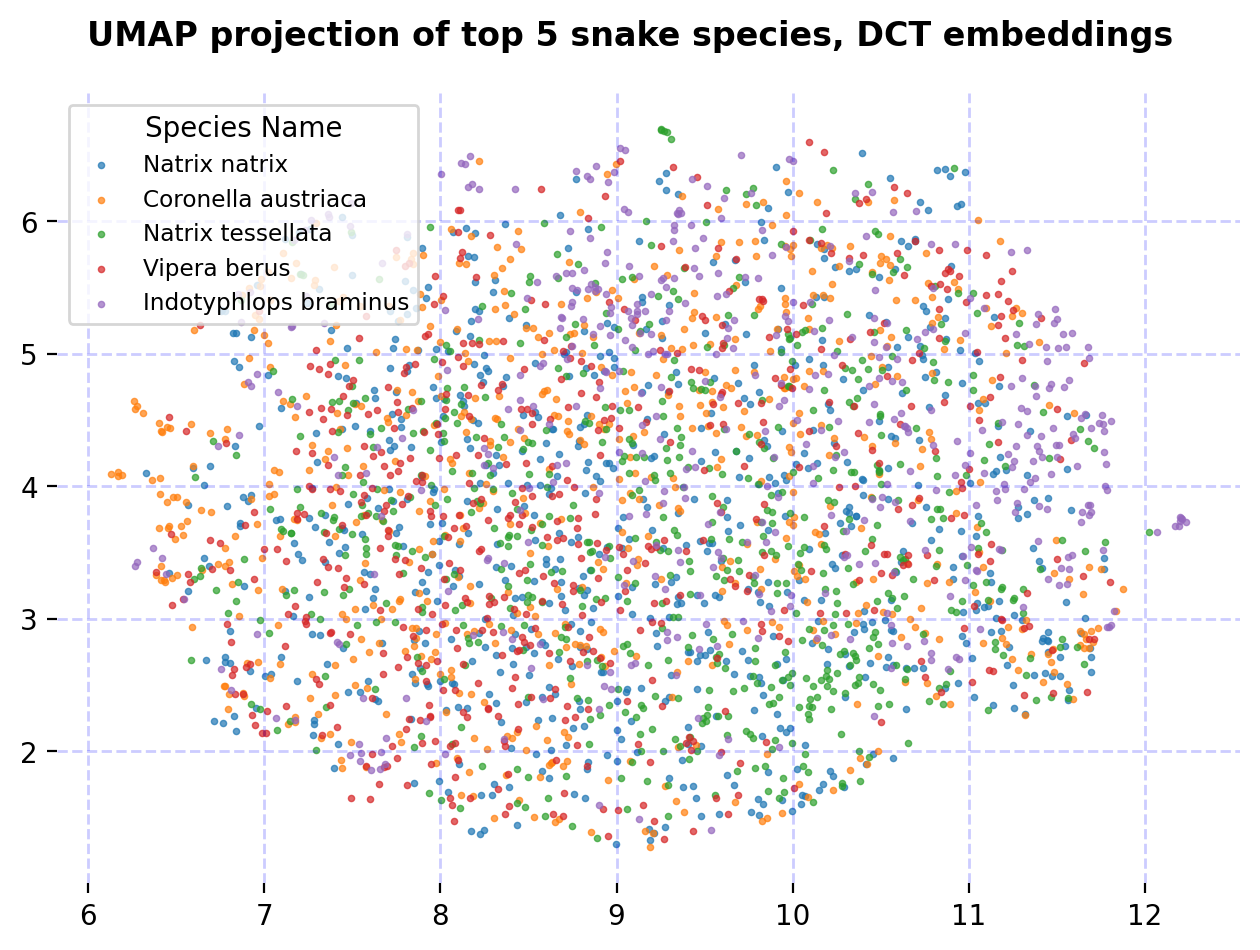

In [9]:
plot_cluster(dct_pandas_df, dct_embedding, algorithm_name="UMAP", emb_name="DCT")

In [10]:
# Get dataframe
cls_sub_df = prepare_emb_df(
    df=cls_df, train_df=train_df, col_name="cls_embedding", num_top_species=5
)

Top 5 class ids: [1137, 387, 1138, 1736, 849]


### PaCMAP projection

In [11]:
import pacmap


def get_pacmap_embedding(embedding):
    # PaCMAP
    pacmap_embedding = pacmap.PaCMAP(
        n_components=2, n_neighbors=15, MN_ratio=0.5, FP_ratio=2.0
    )

    # fit the data
    pacmap_transformed = pacmap_embedding.fit_transform(embedding, init="pca")
    return pacmap_transformed

In [12]:
dct_pacmap_transformed = get_pacmap_embedding(embedding=dct_embedding)

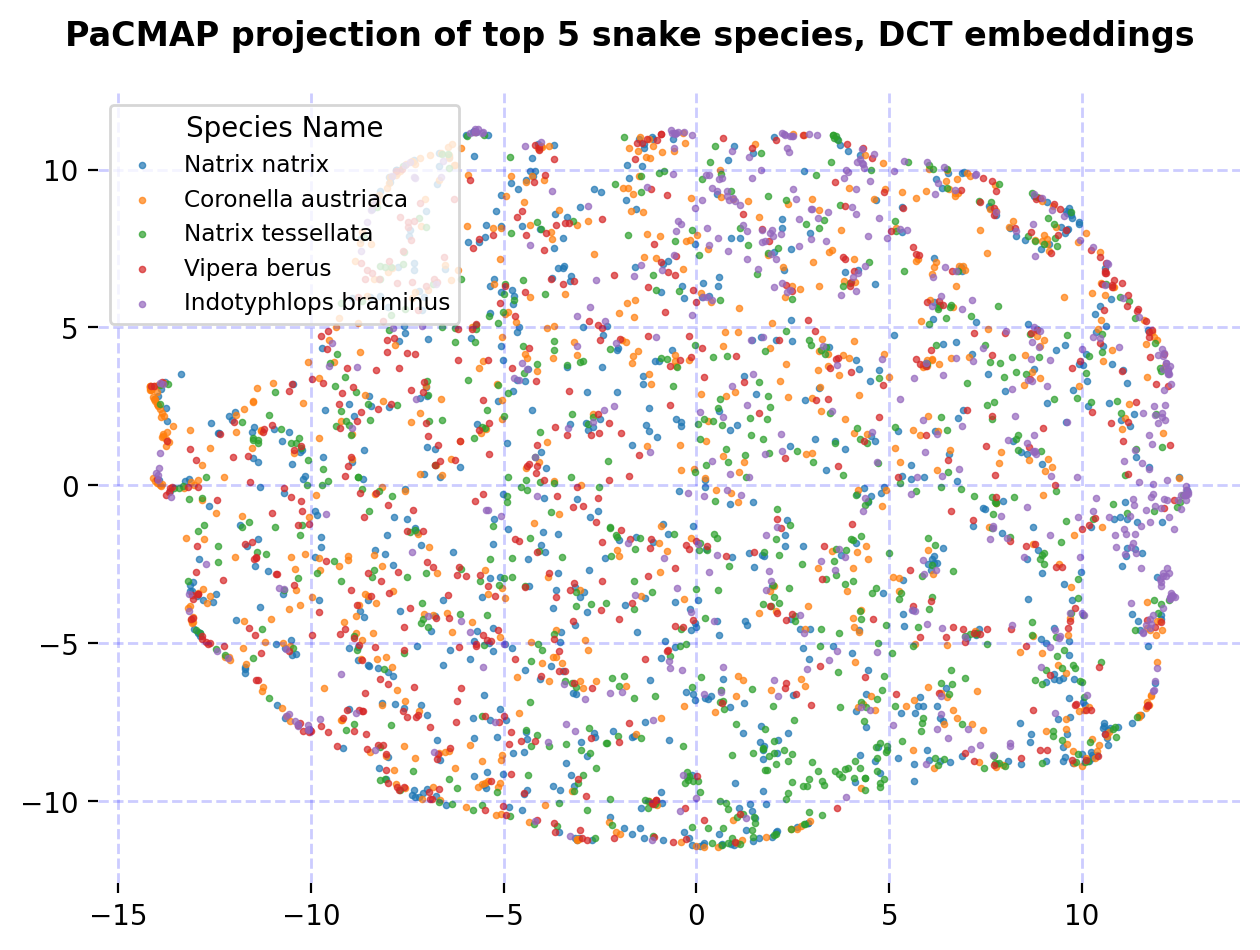

In [13]:
plot_cluster(
    dct_pandas_df, dct_pacmap_transformed, algorithm_name="PaCMAP", emb_name="DCT"
)

## CLS token embeddings

In [14]:
# get pandas_df, embeddings
cls_pandas_df, cls_embedding, cls_scaled_emb = get_pandas_embeddings(
    df=cls_sub_df, col_name="cls_embedding"
)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


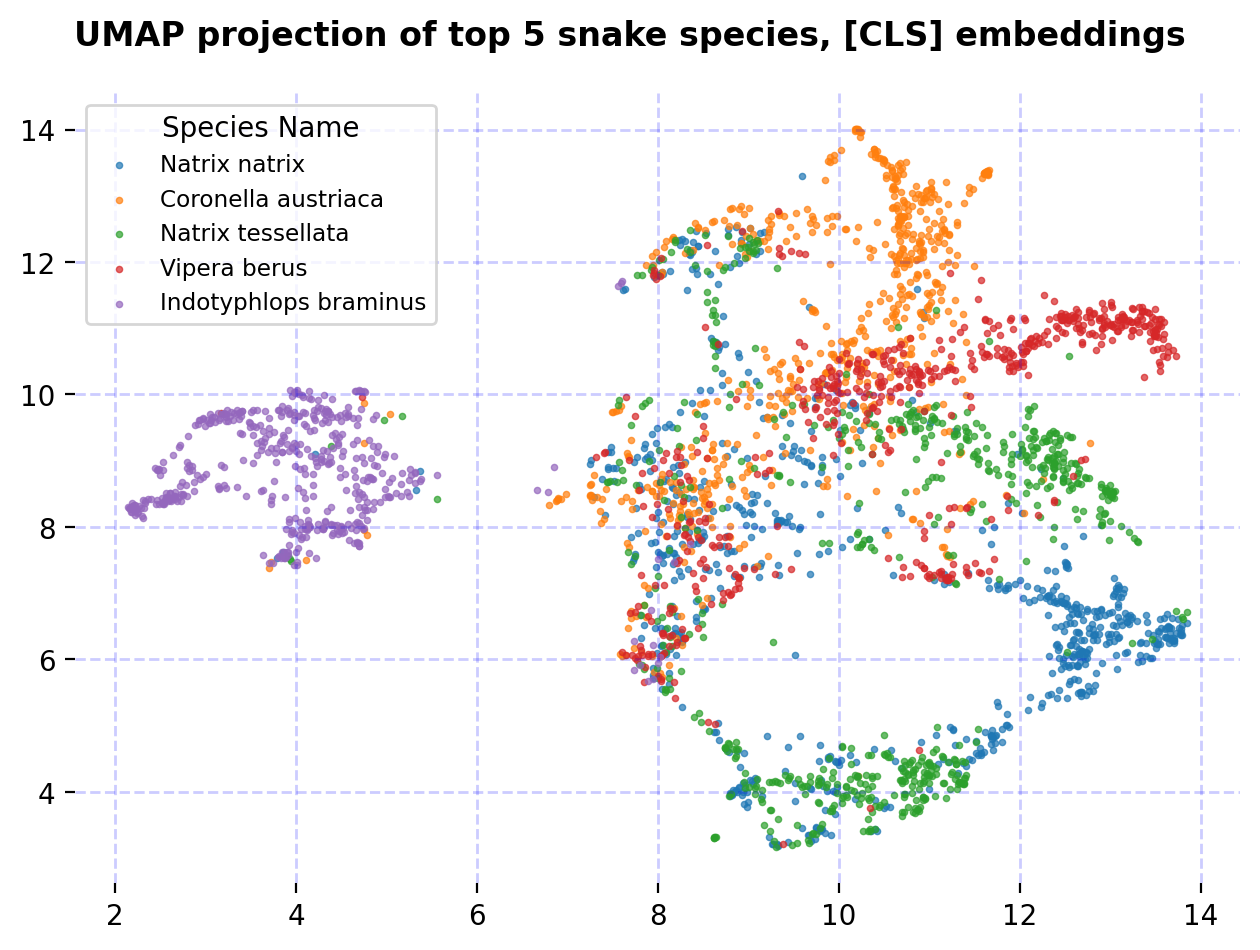

In [15]:
# plot embeddings
plot_cluster(cls_pandas_df, cls_embedding, algorithm_name="UMAP", emb_name="CLS")

### CLS token PaCMAP projection

In [16]:
cls_pacmap_transformed = get_pacmap_embedding(cls_embedding)

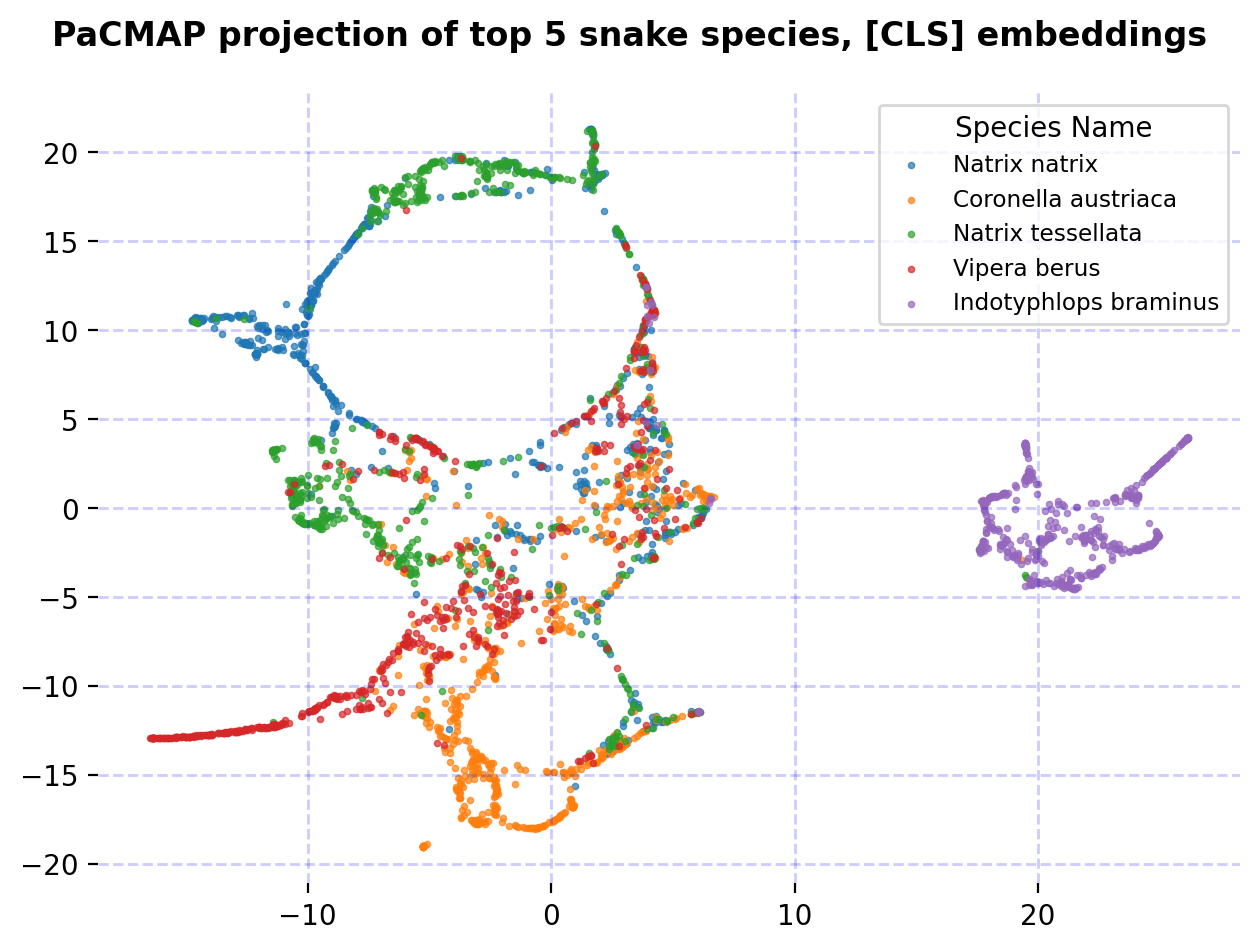

In [17]:
plot_cluster(
    cls_pandas_df, cls_pacmap_transformed, algorithm_name="PaCMAP", emb_name="CLS"
)

## Subset of selected snake species

In [18]:
def prepare_subset_emb_df(
    df: DataFrame, train_df: DataFrame, col_name: str, species_names: list
):
    # Get top species DF
    selected_species = [
        int(row["class_id"])
        for row in train_df.where(F.col("binomial_name").isin(species_names)).collect()
    ]

    subset_df = df.filter(F.col("class_id").isin(selected_species)).select(
        ["path", "class_id", col_name]
    )

    subset_df = subset_df.join(train_df, "path", "inner").select(
        [subset_df.class_id, train_df.binomial_name, subset_df[col_name]]
    )
    return subset_df

In [19]:
species_names = [
    "Micrurus_fulvius",
    "Lampropeltis_triangulum",
    "Morelia_spilota",
    "Bitis_gabonica",
    "Agkistrodon_contortrix",
    "Agkistrodon_piscivorus",
]
dct_selected_df = prepare_subset_emb_df(
    df=dct_df, train_df=train_df, col_name="dct_embedding", species_names=species_names
)

In [20]:
# get pandas_df, embeddings
(
    dct_selected_pandas_df,
    dct_selected_embedding,
    dct_selected_scaled_emb,
) = get_pandas_embeddings(df=dct_selected_df, col_name="dct_embedding")

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


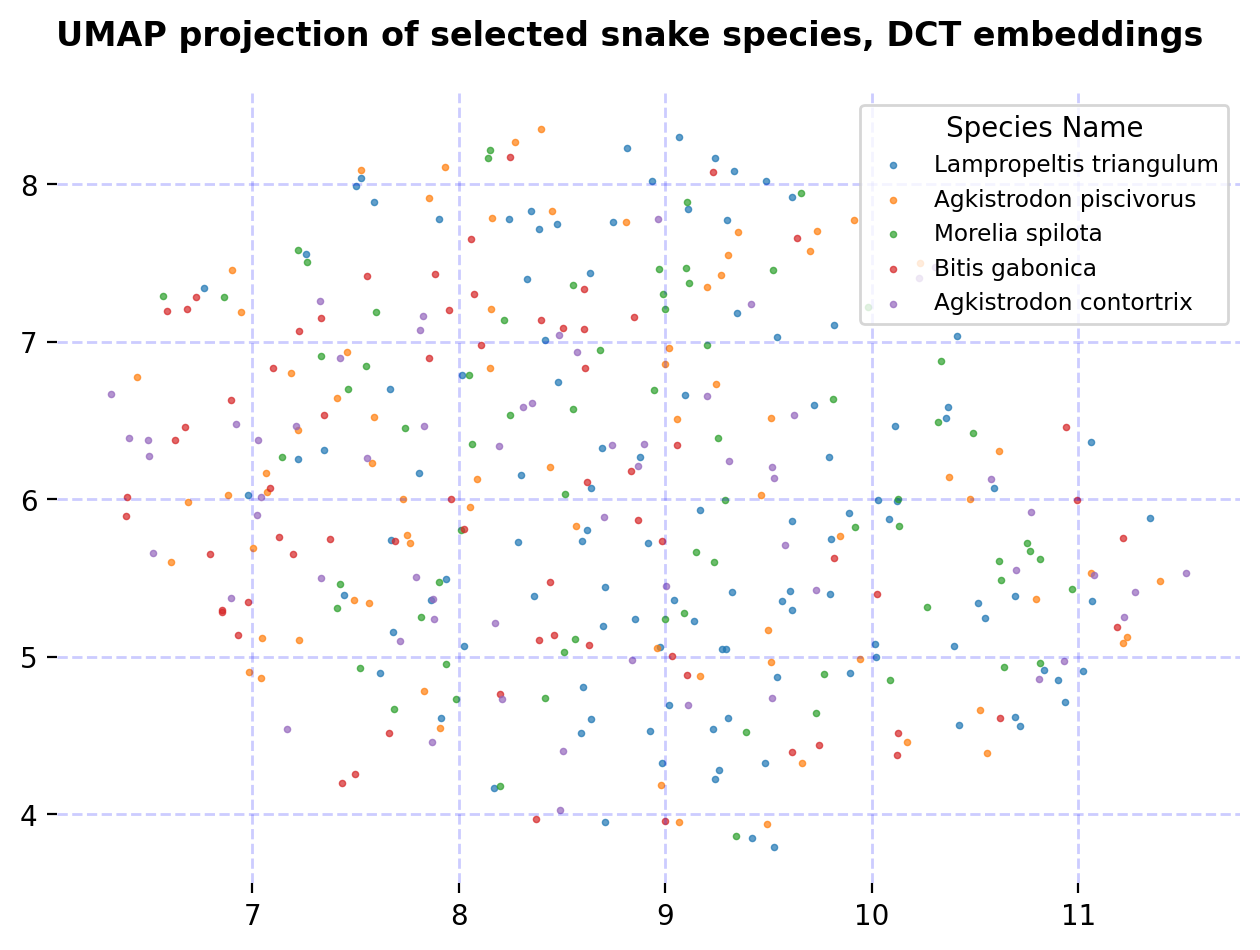

In [21]:
# plot cluster
plot_cluster(
    dct_selected_pandas_df,
    dct_selected_embedding,
    algorithm_name="UMAP",
    emb_name="DCT",
    top_5=False,
)

### CLS token selected species

In [22]:
cls_selected_df = prepare_subset_emb_df(
    df=cls_df, train_df=train_df, col_name="cls_embedding", species_names=species_names
)

In [23]:
# get pandas_df, embeddings
(
    cls_selected_pandas_df,
    cls_selected_embedding,
    cls_selected_scaled_emb,
) = get_pandas_embeddings(df=cls_selected_df, col_name="cls_embedding")

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [24]:
def plot_selected_species_cluster(pandas_df, embeddings):
    # Plot the data
    fig, ax = plt.subplots(figsize=(6.4, 4.8), dpi=200)
    title = f"UMAP projection of selected snake species, [CLS] embeddings"
    fig.suptitle(
        t=title,
        fontsize=12,
        weight="bold",
    )

    # Create a scatter plot, color-coded by new species_idx
    colors = [
        "tab:blue",
        "tab:orange",
        "tab:green",
        "tab:red",
        "tab:purple",
        "tab:brown",
    ]
    top_species_idx = (
        pandas_df["binomial_name"].value_counts().nlargest(len(colors)).index
    )
    species_to_color = {species: colors[i] for i, species in enumerate(top_species_idx)}

    # Map species IDs to colors for plotting
    color_list = pandas_df["binomial_name"].map(species_to_color).tolist()

    for species, color in species_to_color.items():
        # Select embeddings for the current species
        idx = pandas_df["binomial_name"] == species
        ax.scatter(
            embeddings[idx, 0],
            embeddings[idx, 1],
            c=color,
            label=species.replace("_", " "),
            s=5,
            alpha=0.7,
            linewidth=0.5,
        )

    ax.grid(color="blue", linestyle="--", linewidth=1, alpha=0.2)
    ax.legend(loc="best", title="Species Name", fontsize="small")
    for spine in ["top", "right", "bottom", "left"]:
        ax.spines[spine].set_visible(False)
    fig.tight_layout()
    plt.show()

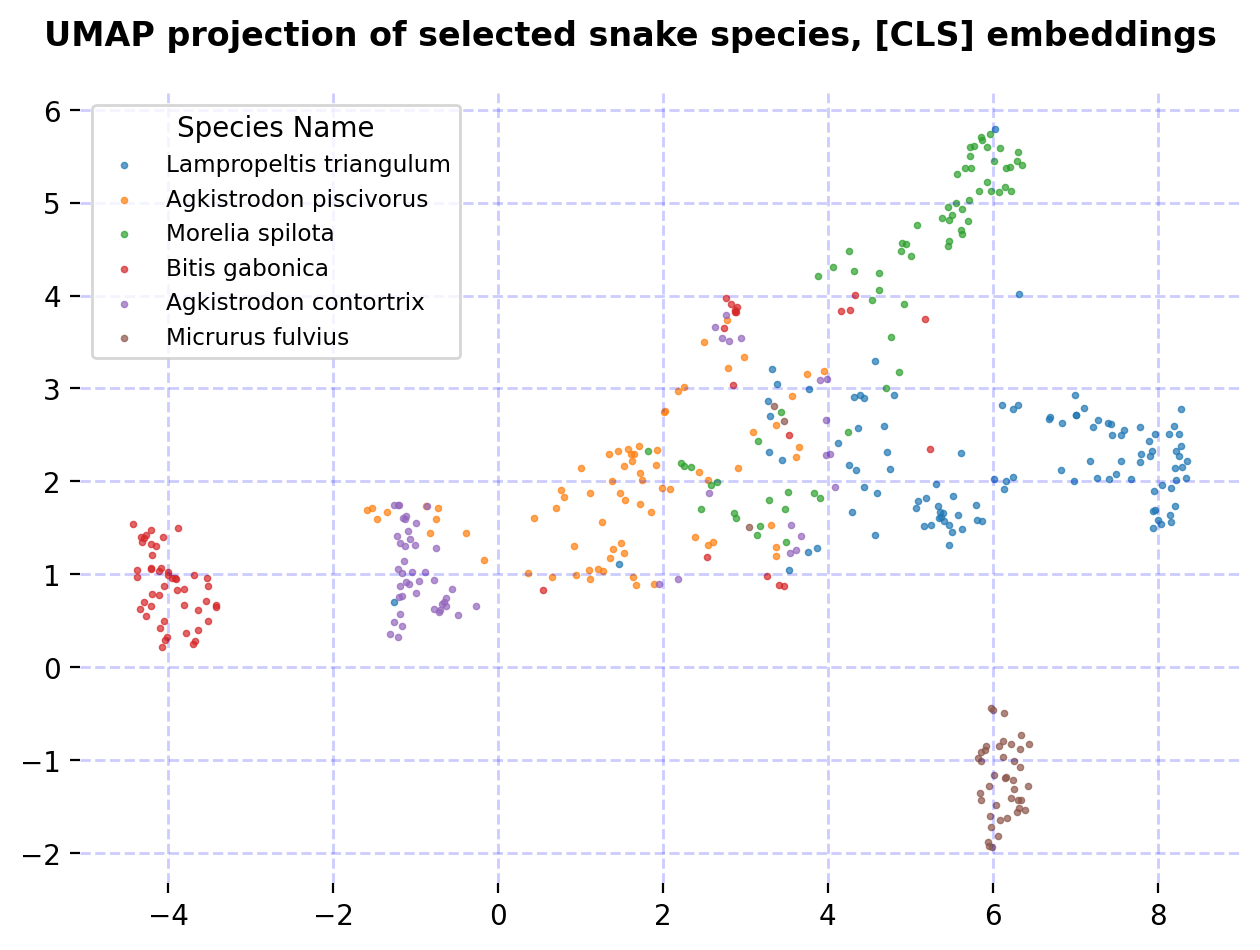

In [25]:
# plot cluster
plot_selected_species_cluster(cls_selected_pandas_df, cls_selected_embedding)